In [2]:
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn as nn
import torch.optim as optim


/home/hice1/dlee906/.conda/envs/my_ml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ClinicalSurvivalDataset(Dataset):
    def __init__(self, hf_dataset, survival_days=730):
        self.samples = []
        for item in hf_dataset:
            if item["days_to_death"] is not None:
                embedding = np.frombuffer(item["embedding"], dtype=np.float32)
                embedding = embedding.reshape(item["embedding_shape"])
                label = 1 if int(item["days_to_death"]) >= survival_days else 0
                self.samples.append((embedding, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        embedding, label = self.samples[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [14]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
dataset = ClinicalSurvivalDataset(clinical_dataset)

# Split into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [40]:
sample_input, _ = next(iter(train_loader))
input_dim =  sample_input.view(sample_input.size(0), -1).shape[1] 

model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [6]:
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        # print(x.shape)
        # print(y.shape)
        output = model(x).squeeze()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x).squeeze() > 0.5
            total_correct += (preds == y.bool()).sum().item()
            total += y.size(0)
    return total_correct / total

In [41]:
train_losses = []
val_accuracies = []
for epoch in range(100):
    train_loss = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1} - Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1 - Loss: 0.6692, Val Acc: 0.5964
Epoch 2 - Loss: 0.6609, Val Acc: 0.5964
Epoch 3 - Loss: 0.6572, Val Acc: 0.5964
Epoch 4 - Loss: 0.6558, Val Acc: 0.5964
Epoch 5 - Loss: 0.6543, Val Acc: 0.5964
Epoch 6 - Loss: 0.6548, Val Acc: 0.5964
Epoch 7 - Loss: 0.6618, Val Acc: 0.5964
Epoch 8 - Loss: 0.6586, Val Acc: 0.5964
Epoch 9 - Loss: 0.6584, Val Acc: 0.5964
Epoch 10 - Loss: 0.6571, Val Acc: 0.5964
Epoch 11 - Loss: 0.6604, Val Acc: 0.5964
Epoch 12 - Loss: 0.6545, Val Acc: 0.5964
Epoch 13 - Loss: 0.6506, Val Acc: 0.5964
Epoch 14 - Loss: 0.6494, Val Acc: 0.5964
Epoch 15 - Loss: 0.6466, Val Acc: 0.5978
Epoch 16 - Loss: 0.6530, Val Acc: 0.5964
Epoch 17 - Loss: 0.6462, Val Acc: 0.5978
Epoch 18 - Loss: 0.6436, Val Acc: 0.6117
Epoch 19 - Loss: 0.6402, Val Acc: 0.6408
Epoch 20 - Loss: 0.6429, Val Acc: 0.6241
Epoch 21 - Loss: 0.6421, Val Acc: 0.6033
Epoch 22 - Loss: 0.6366, Val Acc: 0.6463
Epoch 23 - Loss: 0.6441, Val Acc: 0.6172
Epoch 24 - Loss: 0.6320, Val Acc: 0.6241
Epoch 25 - Loss: 0.6332, 

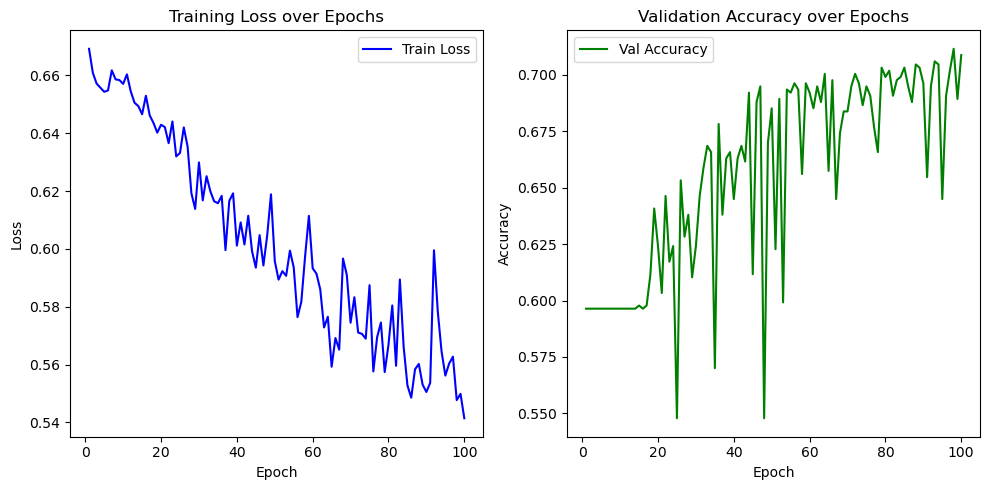

In [42]:
import matplotlib.pyplot as plt

epochs = range(1, 101)  # 100 epochs

plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


MULTIMODAL

In [15]:
class MultiModalModel(nn.Module):
    def __init__(self, input_dims, hidden_dim=64, embedding_dim=32, num_classes=2):
        super(MultiModalModel, self).__init__()

        self.clinical_mlp = MLP(input_dims['clinical'], hidden_dim, embedding_dim)
        self.molecular_mlp = MLP(input_dims['molecular'], hidden_dim, embedding_dim)
        self.pathology_mlp = MLP(input_dims['pathology'], hidden_dim, embedding_dim)

        concat_dim = embedding_dim * 3

        self.classifier = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

        self.survival_head = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # survival time (regression)
        )

    def forward(self, clinical_x, molecular_x, pathology_x):
        clinical_embed = self.clinical_mlp(clinical_x)
        molecular_embed = self.molecular_mlp(molecular_x)
        pathology_embed = self.pathology_mlp(pathology_x)

        combined = torch.cat([clinical_embed, molecular_embed, pathology_embed], dim=1)
        class_output = self.classifier(combined)
        survival_output = self.survival_head(combined)

        return class_output, survival_output

In [16]:
from torch.utils.data import Dataset
import numpy as np
import torch

class MultiModalSurvivalDataset(Dataset):
    def __init__(self, clinical_hf_dataset, molecular_hf_dataset, pathology_hf_dataset, survival_days=730):
        self.samples = []
        
        for clinical_item, molecular_item, pathology_item in zip(clinical_hf_dataset, molecular_hf_dataset, pathology_hf_dataset):
            if clinical_item["days_to_death"] is not None:
                # Clinical Data Processing
                clinical_embedding = np.frombuffer(clinical_item["embedding"], dtype=np.float32)
                clinical_embedding = clinical_embedding.reshape(clinical_item["embedding_shape"])
                
                # Molecular Data Processing
                molecular_embedding = molecular_item["Embeddings"]
                
                # Pathology Data Processing
                pathology_embedding = pathology_item.get("embedding", None)
                if pathology_embedding is None:
                    continue
                
                pathology_embedding = np.frombuffer(pathology_embedding, dtype=np.float32)
                pathology_embedding = pathology_embedding.reshape(pathology_item["embedding_shape"])
                
                # Label based on survival days
                label = 1 if int(clinical_item["days_to_death"]) >= survival_days else 0
                
                # Add the combined data and label to the sample list
                self.samples.append((clinical_embedding, molecular_embedding, pathology_embedding, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        clinical_embedding, molecular_embedding, pathology_embedding, label = self.samples[idx]
        return (torch.tensor(clinical_embedding, dtype=torch.float32), 
                torch.tensor(molecular_embedding, dtype=torch.float32), 
                torch.tensor(pathology_embedding, dtype=torch.float32), 
                torch.tensor(label, dtype=torch.float32))


In [24]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

In [13]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
pathology_report_dataset = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="gatortron")

molecular_dataset = load_dataset("Lab-Rasool/TCGA", "molecular", split="senmo")
dataset = MultiModalSurvivalDataset(clinical_dataset, molecular_dataset, pathology_report_dataset)

In [25]:
# 2. Get input dimensions
sample = dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2].shape)
clinical_dim = sample[0].shape[-1]
molecular_dim = sample[1].shape[0]
pathology_dim = sample[2].shape[0]

input_dims = {
    'clinical': clinical_dim,
    'molecular': molecular_dim,
    'pathology': pathology_dim
}

# 3. Initialize model, dataloader, loss functions, optimizer
model = MultiModalModel(input_dims).cuda()  # or .to(device) if you're managing device explicitly

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

criterion_classification = nn.CrossEntropyLoss()
criterion_survival = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


torch.Size([1, 1, 1024])
torch.Size([48])
torch.Size([1024])


In [31]:

# 4. Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss, total_cls_loss, total_surv_loss = 0, 0, 0
    
    for batch in dataloader:
        # batch = np.array(batch)
        # print(batch.shape)
        clinical_x, molecular_x, pathology_x, labels = batch
        clinical_x = clinical_x.cuda()
        molecular_x = molecular_x.cuda()
        pathology_x = pathology_x.cuda()
        labels = labels.cuda()


        optimizer.zero_grad()
        class_output, survival_output = model(clinical_x, molecular_x, pathology_x)
        
        loss_cls = criterion_classification(class_output, labels)
        loss_surv = criterion_survival(survival_output.squeeze(), survival_days)
        loss = loss_cls + loss_surv

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += loss_cls.item()
        total_surv_loss += loss_surv.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {total_loss:.4f} | Classification Loss: {total_cls_loss:.4f} | Survival Loss: {total_surv_loss:.4f}")


RuntimeError: Tensors must have same number of dimensions: got 4 and 2